In [70]:
from astropy.io import fits
import jax
import jax.numpy as jnp
import sys
import scipy.io

import os
import datetime
import glob
import h5py
import copy


sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import numpy as np

import jabble.model
import jabble.dataset
import jabble.loss
import jabble.quickplay

import astropy.coordinates as coord
import astropy.time as at
import astropy.units as u

jax.config.update("jax_enable_x64", True)

In [2]:
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

<h1>03-Extract Data from KOA files</h1>
In this notebook, I extract the flux, wavelength, error data from many KOA data fits file. And store the important information in arrays that will used for fitting by jabble.

In [3]:
file_names = 'KOA_68585/HIRES/extracted/**/*_flux.fits' #+ ['KOA_123937_{}/HIRES/extracted/**/*_flux.fits'.format(x) for x in range(2,16)]
folder_names = os.path.join('/scratch/mdd423/wobble_jax/data/gj436_hires',file_names)
files = glob.glob(folder_names, 
                   recursive = True)

In [4]:
hdu1 = fits.open(files[0])

In [12]:
hdu1[0].header['*OBJ*']

OBJECT  = 'object (Flux)'                                                       
OBJFILE = 'HI.20080319.419:  167  500 none  ng3   kv370 -0.0290 -0.1290 B5'     
OBJPOS01= '-0.01956     1.66744'                                                
OBJPOS02= '-0.02326     1.66744'                                                
OBJPOS03= '-0.02440     1.66744'                                                
OBJPOS04= '-0.02373     1.66744'                                                
OBJPOS05= '-0.02196     1.66744'                                                
OBJPOS06= '-0.01984     1.66744'                                                
OBJPOS07= '-0.01810     1.66744'                                                
OBJPOS08= '-0.01748     1.66744'                                                
OBJPOS09= '-0.01871     1.66744'                                                
OBJPOS10= '-0.02251     1.66744'                                                
ARC2OBJ = 'Arc-167_3.fits Fl

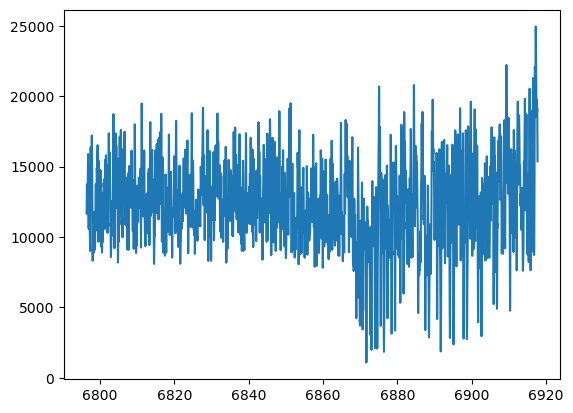

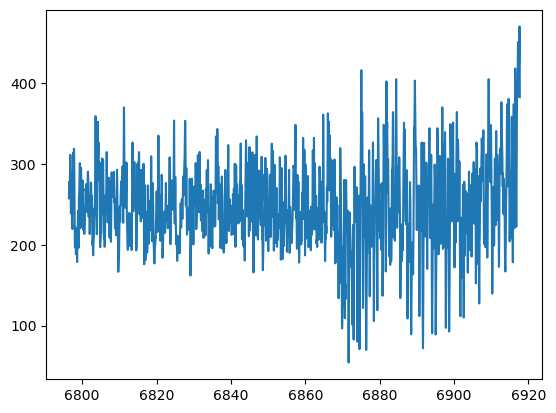

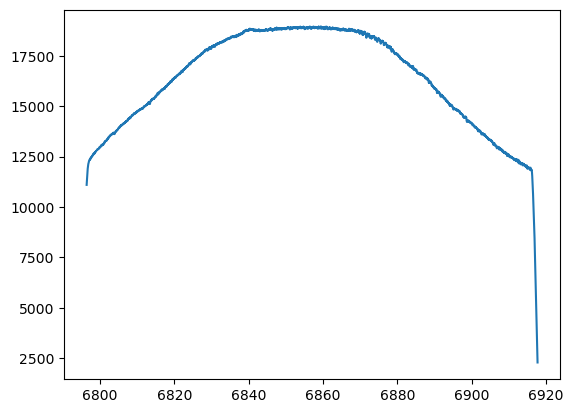

In [7]:
plt.plot(hdu1[1].data['wave'],hdu1[1].data['flux'])
plt.show()
plt.plot(hdu1[1].data['wave'],hdu1[1].data['Background'])
plt.show()
plt.plot(hdu1[1].data['wave'],hdu1[1].data['Flat'])
plt.show()

In [8]:
observatory_name = 'Keck'
loc = coord.EarthLocation.of_site(observatory_name)
star_name = hdu1[0].header['TARGNAME']
star = coord.SkyCoord.from_name(star_name,parse=True)

In [39]:
valid_target = ['36-Gl436(STD)', 'GJ 436', 'GJ436', 'HIP57087', 'gl436','gl436_M3V', 'hip 57087', 'hip57087']
valid_object = ['(Flux)', 'GJ 436 (Flux)', 'GJ 436 +I2 (Flux)', 'GJ436 (Flux)',\
        'HIP57087 (Flux)','Object (Flux)',\
        'Star+Iodine (Flux)',\
        'hip57087 (Flux)', 'k71 (Flux)', 'k72 (Flux)',\
        'k75 (Flux)', 'k80 (Flux)', 'k81 (Flux)', 'k82 (Flux)',\
        'k83 (Flux)', 'k86 (Flux)', 'k88 (Flux)', 'object (Flux)',\
        'star (Flux)']

def get_order_files(all_files):
    all_orders = []
    wavemins = []
    name_arr = []

    for filename in files:
        try:
            hdu1 = fits.open(filename)
            
            if hdu1[0].header['TARGNAME'] in valid_target:
                if hdu1[0].header['OBJECT'] in valid_object:
                    name_arr.append(filename)
                    all_orders.append(hdu1[0].header['ECHL_ORD'])
                    wavemins.append(np.min(hdu1[1].data['wave']))

            #         if hdu1[0].header['ECHL_ORD'] is echelle_order:
            #             try:
            #                 jd = '{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UTC'])#, format='isot', scale='utc')
            #             except:
            #                 jd = '{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UT'])#, format='isot', scale='utc')
                    
            #             # print(hdu1[0].header['TARGNAME'],hdu1[0].header['OBJECT'])
                        
            #             # times.append(jd)
                        # wavemins.append(np.min(hdu1[1].data['wave']))
            #             # orders.append(hdu1[0].header['ECHL_ORD'])
                        
        except OSError:
            print(filename)
    assert len(all_orders) == len(name_arr)
    assert len(all_orders) == len(wavemins)
    
    for echelle_order in np.unique(all_orders):
        mask = np.array(all_orders) == echelle_order
        median_wave = np.median(np.array(wavemins)[mask])
        mask_waves = np.abs(np.array(wavemins) - median_wave) < 5
        total_mask = (~mask_waves.astype(bool)) * mask.astype(bool)

        indices, = np.where(total_mask)
        for index in sorted(indices,reverse=True):
            all_orders.pop(index)
            name_arr.pop(index)
            wavemins.pop(index)
    
    return name_arr, all_orders
name_arr, all_orders = get_order_files(files)

/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_06_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_05_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_08_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_04_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd3/flux/HI.20111207.47765_3_07_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_05_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_12_flux.fits
/scratch/mdd423/wobble_jax/data/gj436_hires/KOA_68585/HIRES/extracted/binaryfits/ccd1/flux/HI.20111207.47765_1_13_flux.fits
/scratch

In [40]:
len(name_arr),len(all_orders)

(10045, 10045)

In [17]:
np.unique(targname_list),np.unique(object_list)

(array(['156668', '36-Gl436(STD)', 'GJ 436', 'GJ436', 'HIP57087', 'gl436',
        'gl436_M3V', 'hip 57087', 'hip57087'], dtype='<U13'),
 array(['(Flux)', 'GJ 436 (Flux)', 'GJ 436 +I2 (Flux)', 'GJ436 (Flux)',
        'HIP57087 (Flux)', 'HR3686 (Flux)', 'HR4456 (Flux)',
        'HR5511 (Flux)', 'HR5849 (Flux)', 'Iodine (Flux)', 'Object (Flux)',
        'Star+Iodine (Flux)', 'ThAr (Flux)', 'WideFlat (Flux)',
        'flat (Flux)', 'hip57087 (Flux)', 'k71 (Flux)', 'k72 (Flux)',
        'k75 (Flux)', 'k80 (Flux)', 'k81 (Flux)', 'k82 (Flux)',
        'k83 (Flux)', 'k86 (Flux)', 'k88 (Flux)', 'object (Flux)',
        'planet test (Flux)', 'sky (Flux)', 'star (Flux)',
        'wideflat (Flux)'], dtype='<U18'))

<h2>Loading in Data from Directories Here</h2>
Searches the directory for all flux files as downloaded from Keck Online Archive (KOA).

In [78]:
def get_dataset(files,epsilon=np.exp(-11)):
    iteration = 0
    airmasses = np.zeros(shape=(0))
    bcs = np.zeros(shape=(0))
    jds = np.zeros(shape=(0))
    filenames = np.zeros(shape=(0))
    objnames = np.zeros(shape=(0))
    fluxes   = []
    waves    = []
    yivar    = []
    mask = []
    for file in files:
        
        try:
            hdu1 = fits.open(file)
        except:
            print(file)
            continue
            
        airmass = float(hdu1[0].header['AIRMASS'])
        
        flux = jnp.array(hdu1[1].data['flux'],dtype=np.float64)
        xs = jnp.log(jnp.array(hdu1[1].data['wave'],dtype=np.float64))
        ys = jnp.log(flux)
        yerr = jnp.array(hdu1[1].data['Error'],dtype=np.float64)/flux
        ma = np.isnan(yerr) | np.isinf(yerr) | np.isinf(flux) | (flux <= epsilon) | np.isnan(flux)
        objname = hdu1[0].header['OBJFILE']

        try:
            jd = at.Time('{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UTC']), format='isot', scale='utc')
        except:
            jd = at.Time('{}T{}'.format(hdu1[0].header['DATE-OBS'],hdu1[0].header['UT']), format='isot', scale='utc')
            
        fluxes.append(ys)
        waves.append(xs)
        yivar.append(1/yerr**2)
        mask.append(ma)
        
        bc = star.radial_velocity_correction(obstime=jd, location=loc).to(u.m/u.s).value

        airmasses = np.concatenate((airmasses,[airmass]))
        bcs = np.concatenate((bcs,[bc]))
        jds = np.concatenate((jds,[jd.jd]))
        filenames = np.concatenate((filenames,[file]))
        objnames = np.concatenate((objnames,[objname]))
        
    dataset = jabble.dataset.Data.from_lists(waves,fluxes,yivar,mask)
    dataset.metadata['times'] = jds
    dataset.metadata['airmasses'] = airmasses

    return dataset, airmasses, bcs, jds

In [68]:
def get_normalization_model(dataset, norm_p_val: int, norm_pts: int):
    len_xs = np.max(
        [np.max(dataframe.xs) - np.min(dataframe.xs) for dataframe in dataset]
    )
    min_xs = np.min([np.min(dataframe.xs) for dataframe in dataset])
    max_xs = np.max([np.max(dataframe.xs) for dataframe in dataset])

    shifts = jnp.array([dataframe.xs.min() - min_xs for dataframe in dataset])
    x_spacing = len_xs / norm_pts
    x_grid = jnp.linspace(-x_spacing*((norm_p_val + 1)//2), len_xs + (x_spacing*((norm_p_val + 1)//2)), norm_pts + norm_p_val + 1) + min_xs
    model = jabble.model.CardinalSplineMixture(x_grid, norm_p_val)
    size = len(dataset)

    p = jnp.tile(model.p, size)
    norm_model = jabble.model.NormalizationModel(p, model, size)
    return jabble.model.ShiftingModel(shifts).composite(norm_model)

def get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_vels,airmass):
         
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = jnp.arange(np.min(np.concatenate(dataset.xs)), np.max(np.concatenate(dataset.xs)), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  
    init_shifts = jabble.physics.shifts(init_rvs)
    rest_shifts = jabble.physics.shifts(rest_vels)
    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts,which_key='times'),#ShiftingModel(init_shifts),#
            jabble.model.CardinalSplineMixture(model_grid, p_val),
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(rest_shifts,which_key='times'),
            jabble.model.CardinalSplineMixture(model_grid, p_val),
            jabble.model.StretchingModel(jnp.array(airmass)),
        ]
    )

    # model.to_device(device)

    # model.fit(2)
    # print(type(model.get_parameters()),model.get_parameters().devices())
    return model

In [64]:
def train_norm(model, dataset, loss, device_store, device_op, batch_size,nsigma = [0.5,2], maxiter=3):
    options = {"maxiter": 4096,\
               "factr": 1e4,\
              }
    # Fit Normalization Template
    for iii in range(maxiter):
        model.fix()
        model.fit(2, 1)
        
        res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
        print(res1)
        model.fix()
        _,metablock = dataset.blockify(device_op)
        for data_epoch in range(len(dataset)):

            mask    = dataset[data_epoch].mask
            metarow = jabble.loss.dict_ele(metablock,data_epoch,device_op)
            resid = dataset[data_epoch].ys - model([],dataset[data_epoch].xs,metarow)
            sigma = np.sqrt(np.nanmedian(resid**2))
            m_new = (resid < -nsigma[0]*sigma) | (resid > nsigma[1]*sigma)
            dataset[data_epoch].mask = mask | m_new[:len(mask)]

    return model

def train_cycle(model, dataset, loss, device_store, device_op, batch_size):
    options = {"maxiter": 8,\
               "factr": 10.0,\
              }

    # Fit Stellar & Telluric Template
    model.fix()
    model.fit(0,1)
    model.fit(1,1)
    model.display()
    
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)
    
    # Fit RV
    model.fix()
    model.fit(0,0)
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)
    print(res1)

    # RV Parabola Fit
    # model.fix()
    # search_space = np.linspace(-100, 100, 500)
    # shift_search = jabble.physics.shifts(search_space)

    # sgrid = model[0][0].p[:,None] + shift_search[None,:]
    # lgrid = model[0][0].grid_search(sgrid, loss, model, dataset, device_op)
    
    # for i in range(lgrid.shape[0]):
    #     if np.argmin(lgrid[i,:]) == 0 or np.argmin(lgrid[i,:]) == lgrid.shape[1] - 1:
    #         plt.plot(shift_search,lgrid[i,:])
    #         plt.show()
    
    # model[0][0].parabola_fit(shift_search, loss, model, dataset, device_op, device_store)
    # model.to_device(device_op)

    # Fit Everything
    model.fix()
    model.fit(0,0)
    model.fit(0,1)
    model.fit(1,1)
    # model.fit(2,1)

    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)

    return model

In [65]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")

echelle_order = 51
resolution = 85_000
p_val = 3
vel_padding = 100 * u.km / u.s

lmb = 1e-6

norm_p_val = 2
norm_pts   = 3

star_name = 'GJ436'
os.makedirs(os.path.join(out_dir,star_name),exist_ok=True)
print(np.unique(all_orders))

[ 39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98 119]


In [48]:
# def plot_dataset(dataset,epoch,ax,lrange,offset=0.0):
#     if dataset[epoch].ys.shape == (4056,):
#         ax.errorbar(dataset[epoch].xs[~dataset[epoch].mask],dataset[epoch].ys[~dataset[epoch].mask] - y_mean[~dataset[epoch].mask] + offset,\
#                          yerr=1/np.sqrt(dataset[epoch].yivar[~dataset[epoch].mask]),fmt='.',zorder=2,alpha=0.5,ms=0.4)
#         ax.set_xticks(np.log(lrange))
#         ax.set_xticklabels(['{}'.format(x) for x in lrange])
#         ax.set_xlim(np.log(lrange.min()),np.log(lrange.max()))

# plt_epoches = np.arange(0,len(dataset),dtype=int)
# fig, ax = plt.subplots(1,figsize=(8,8),\
#                              facecolor=(1, 1, 1),dpi=200)

# lrange = np.arange(6980,7000,1)
# for epoch in plt_epoches:
#     plot_dataset(dataset,epoch,ax,lrange,offset)
#     offset += 0.3
# plt.show()

In [80]:
device_store = cpus[0]
device_op = cpus[0]
batch_size = 5000

# out_dir = '/scratch/mdd423/wobble_jax/out/25-07-09/'
for echelle_order in np.unique(all_orders):

    data_name = os.path.join(out_dir,star_name,'{}_data_o{}_norm.pkl'.format(star_name,echelle_order))
    model_name = os.path.join(out_dir,star_name,'{}_model_o{}_norm.pkl'.format(star_name,echelle_order))
    if not os.path.isfile(model_name) or True:
        # order_files, _ = get_order_files(files,echelle_order)
        name_mask = echelle_order == all_orders
        # print(echelle_order,np.sum(name_mask))
        if np.sum(name_mask) > 100:
            dataset, airmasses, bcs, jds = get_dataset(np.array(name_arr)[name_mask])
            norm_dataset = copy.deepcopy(dataset)
                    
            init_rvs = bcs
            rest_rvs = np.zeros(init_rvs.shape)#ccf_arr_obj['ccf_rvc'] - ccf_arr_obj['ccf_rvs']
            print(init_rvs.shape,rest_rvs.shape)
            dataset.metakeys['times'] = jds
            
            model =  get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_rvs,airmasses)
            norm_model = get_normalization_model(dataset,norm_p_val,norm_pts)
            model += norm_model
            print(dataset.yivar)
            reg_s = lmb*jabble.loss.L2Reg([0,1]) * np.nansum(dataset.yivar)
            reg_t = lmb*jabble.loss.L2Reg([1,1]) * np.nansum(dataset.yivar)
            model.metadata = dataset.metadata
    
            loss = jabble.loss.ChiSquare()
    
            model.display()
    
            model = train_norm(model, norm_dataset, loss, device_store, device_op, batch_size,maxiter=2,nsigma=[0.3,3])
            model = train_cycle(model, dataset, loss + reg_s + reg_t, device_store, device_op, batch_size)
    
            rv_model = model
            for ii in [0,0]:
                rv_model = rv_model[ii]
            rv_model.display()
            
            jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0][0].p,device=device_op,loss=loss,rv_ind=[0,0])
    else:
        print('skipping order {}'.format(echelle_order))

# fig, axes = plt.subplots(3,1,figsize=(4*len(model_inds),8),sharex='col',sharey='row',\
#                              facecolor=(1, 1, 1),height_ratios=[4,4,1],dpi=200)


# # plt_width = np.arange(-40,40,20) + 10
# plt_epoch = 0

# lrange = np.linspace(int(np.min(np.exp(dataset[plt_epoch].xs))),int(np.max(np.exp(dataset[plt_epoch].xs))),4)[:,None]
# # lrange = np.array([np.mean(np.exp(dataset[plt_epoch].xs)) for plt_epoch in plt_epoches]).astype(int)[None,:] + plt_width[:,None]

# # lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 

# plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
# axes[0] = make_subplot_norm(axes[0],model,dataset,norm_dataset,plt_epoches[0],cpus[0],lrange[:,0])

# plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
# # axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
# axes[1:] = make_subplot(axes[1:],model,dataset,plt_epoches[0],cpus[0],lrange[:,0])
# fig.text(0.5, 0.04, 'Wavelength [$\\AA$]', ha='center')
# plt.show()
# jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0][0].p,\
#                                           device=device_op,loss=loss+reg_s+reg_t)

(230,) (230,)
[Array([9.83452181e+03, 1.17334640e+04, 1.53597578e+04, ...,
       5.28947791e+09, 5.28947791e+09, 5.28947791e+09], dtype=float64), Array([3.46207905e+03, 4.43200758e+03, 5.43612847e+03, ...,
       4.24813075e+07, 4.24813075e+07, 4.24813075e+07], dtype=float64), Array([4.71563769e+03, 5.98694325e+03, 6.60358845e+03, ...,
       1.72909424e+09, 1.72909424e+09, 1.72909424e+09], dtype=float64), Array([9.27685927e+03, 1.35743099e+04, 1.72157330e+04, ...,
       1.31199614e+10, 1.31199614e+10, 1.31199614e+10], dtype=float64), Array([9.49818110e+03, 1.19064375e+04, 1.38020331e+04, ...,
       2.64298851e+09, 2.64298851e+09, 2.64298851e+09], dtype=float64), Array([4.15016176e+03, 6.05478324e+03, 8.16337550e+03, ...,
       2.99782169e+09, 2.99782169e+09, 2.99782169e+09], dtype=float64), Array([5.47709323e+03, 6.94728577e+03, 8.11669864e+03, ...,
       2.59758728e+09, 2.59758728e+09, 2.59758728e+09], dtype=float64), Array([4.50724035e+09, 4.50724035e+09, 4.50724035e+09, ...,
 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (230,) + inhomogeneous part.